# Learning Deep Convolutional Networks for Demosaicing

> Original paper by Nai-Sheng Syu, Yu-SHeng Chen, Yung-Yu Chuang [[1]](https://arxiv.org/pdf/1802.03769.pdf)

> Homepage for the paper: [link](http://www.cmlab.csie.ntu.edu.tw/project/Deep-Demosaic/) (As of 24.4.2019 the authors have not released the original code)

### About the notebook

This notebook and repository aims to reproduce the state-of-the-art results provided in the [1]. 

**Author:** Eemeli Saari

**Email:** saari.eemeli@gmail.com

**Modified:** 24.4.2019

---

In [1]:
import os

In [2]:
import numpy as np
import torch
import cv2
import matplotlib.pyplot as plt
from torchsummary import summary

We'll set a standard seed for reproducibility.

In [3]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

## Data

We load the data from the authors homepage and define a Pytorch dataset that reads patches from the images.

The image patches are densely extracted $33 \times 33$ patches that are padded with zeros to make up for the missing channels.

In [4]:
from dataset import download_data, ImagePatchDataset

In [6]:
%time dataset = ImagePatchDataset(root=download_data(), sample_size=50, bilin=True)

Wall time: 34.9 s


In [44]:
len(dataset)

25000

In [7]:
data_loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)

## DMCNN-VD Model

Model is defined to have 20 identical convolution layers with each 64 Filters with kernel size of 3. Authors of the papers also used the padding of 1.

There was no simple explanation of the residual layer that was used so the one from [here](https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/02-intermediate/deep_residual_network/main.py) was used.

In [8]:
class DMCNN_VD(torch.nn.Module):
    """DMCNN-VD

    Model adopted from [link](https://arxiv.org/pdf/1802.03769.pdf)
    """
    def __init__(self, n_layers=20):
        super(DMCNN_VD, self).__init__()

        self.n_layers = n_layers
        self.layer0 = torch.nn.Sequential(
            torch.nn.Conv2d(3, 64, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.SELU()
        )
        for i in range(1, self.n_layers):
            setattr(self, f'layer{i}', self.conv_layer)

        # https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/02-intermediate/deep_residual_network/main.py
        self.residual = torch.nn.Sequential(
            torch.nn.Conv2d(64, 3, kernel_size=3, padding=1, bias=False),
            torch.nn.BatchNorm2d(3),
            torch.nn.SELU(inplace=True)
        )
        self.apply(self._msra_init)
            
    def forward(self, x):
        out = getattr(self, 'layer0')(x)
        for i in range(1, self.n_layers):
            out = getattr(self, f'layer{i}')(out)

        out = self.residual(out)

        return out
    
    @property
    def conv_layer(self):
        return torch.nn.Sequential(
            torch.nn.Conv2d(64, 64, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.SELU()
        )

    @property
    def n_params(self):
        return sum(p.numel() for p in model.parameters() if p.requires_grad)

    def _msra_init(self, m):
        # https://easydl.readthedocs.io/en/stable/_modules/easydl/pytorch/pytorch.html
        if isinstance(m, torch.nn.Conv2d):
            n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            m.weight.data.normal_(0, np.sqrt(2./n))
        elif isinstance(m, torch.nn.BatchNorm2d):
            torch.nn.init.constant_(m.weight, 1)
            torch.nn.init.constant_(m.bias, 0)

In [9]:
%time model_vd = DMCNN_VD().cuda()

Wall time: 12.7 s


In [10]:
summary(model_vd, input_size=(3, 33, 33))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 33, 33]           1,792
       BatchNorm2d-2           [-1, 64, 33, 33]             128
              SELU-3           [-1, 64, 33, 33]               0
            Conv2d-4           [-1, 64, 33, 33]          36,928
       BatchNorm2d-5           [-1, 64, 33, 33]             128
              SELU-6           [-1, 64, 33, 33]               0
            Conv2d-7           [-1, 64, 33, 33]          36,928
       BatchNorm2d-8           [-1, 64, 33, 33]             128
              SELU-9           [-1, 64, 33, 33]               0
           Conv2d-10           [-1, 64, 33, 33]          36,928
      BatchNorm2d-11           [-1, 64, 33, 33]             128
             SELU-12           [-1, 64, 33, 33]               0
           Conv2d-13           [-1, 64, 33, 33]          36,928
      BatchNorm2d-14           [-1, 64,

DMCNN-VD is roughly 16x larger model than the shallow DMCNN but it's still a tiny compared to some of the standard networks like VGG16 etc.

## Training the model

The DMCNN-VD uses the same $L_2$ norm for training. However the original CFA is summed to the models residual output which we take into account when already defined the model.

For the optimizer Adam is used with lr parameter $1^{-5}$

In [11]:
criterion = torch.nn.MSELoss()

For this experiment we'll lower the lr to adjust for smaller dataset.

In [12]:
optimizer_vd = torch.optim.Adam(model_vd.parameters(), lr=1e-3)

In [13]:
n_epochs = 250

For this model we'll choose a much larger epoch number and train the model in a similar manner to DMCNN. However we'll be dropping the clipping as the residual learning is used.

In [14]:
device = torch.device('cuda:0')

We can load the model and the latest checkpoint by modifying the `checkpoint_path` variable

In [15]:
weights_path = 'weights'

In [16]:
if not os.path.exists(weights_path):
    os.mkdir(weights_path)

In [17]:
checkpoint_path = None
checkpoint_path = os.path.join(weights_path, checkpoint_path) if checkpoint_path else checkpoint_path

In [18]:
start_epoch = 0

In [19]:
if checkpoint_path and os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model_vd.load_state_dict(checkpoint['model_state_dict'])
    optimizer_vd.load_state_dict(checkpoint['optimizer_state_dict'])
    loss = checkpoint['loss']
    start_epoch = checkpoint['epoch']

In [20]:
start_epoch

0

In [21]:
from utils import checkpoint

Epoch [0/250], Step [0/196], Loss: 1.0032801628112793
Epoch [0/250], Step [50/196], Loss: 0.06273544579744339
Epoch [0/250], Step [100/196], Loss: 0.04413767531514168
Epoch [0/250], Step [150/196], Loss: 0.023863451555371284

Finished Epoch 0, Loss --- mean: 0.11114185206516057, std 0.16073848399446647



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


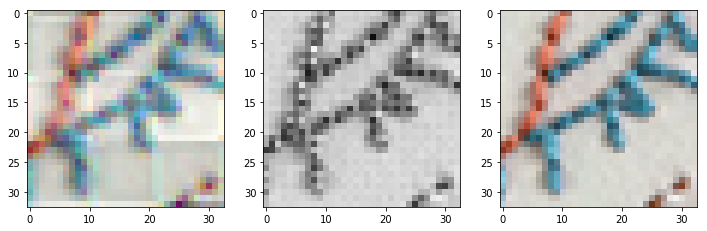

Epoch [1/250], Step [0/196], Loss: 0.044403187930583954
Epoch [1/250], Step [50/196], Loss: 0.01906561478972435
Epoch [1/250], Step [100/196], Loss: 0.04503963142633438
Epoch [1/250], Step [150/196], Loss: 0.020163118839263916

Finished Epoch 1, Loss --- mean: 0.03565053745857155, std 0.014849902873678864



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


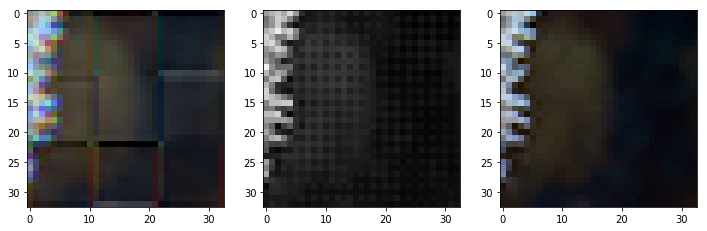

Epoch [2/250], Step [0/196], Loss: 0.0557575598359108
Epoch [2/250], Step [50/196], Loss: 0.02303440123796463
Epoch [2/250], Step [100/196], Loss: 0.05447717383503914
Epoch [2/250], Step [150/196], Loss: 0.022237753495573997


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 2, Loss --- mean: 0.030087411270609925, std 0.009876678566355067



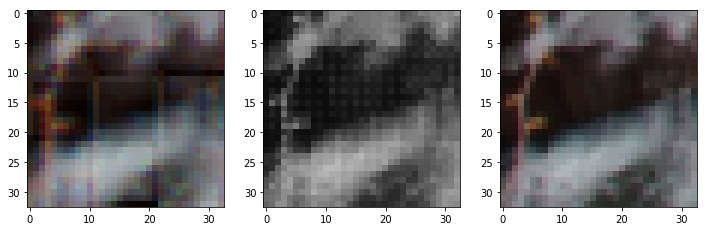

Epoch [3/250], Step [0/196], Loss: 0.025677088648080826
Epoch [3/250], Step [50/196], Loss: 0.07728936523199081
Epoch [3/250], Step [100/196], Loss: 0.016059929504990578
Epoch [3/250], Step [150/196], Loss: 0.19866245985031128


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 3, Loss --- mean: 0.0531314390863539, std 0.047451040198828745



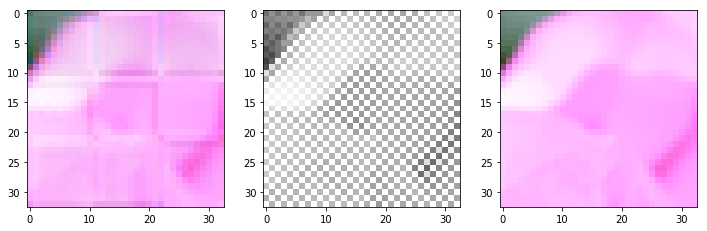

Epoch [4/250], Step [0/196], Loss: 0.032168641686439514
Epoch [4/250], Step [50/196], Loss: 0.02405598759651184
Epoch [4/250], Step [100/196], Loss: 0.016864079982042313
Epoch [4/250], Step [150/196], Loss: 0.025884725153446198


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 4, Loss --- mean: 0.021701914410353924, std 0.010079632660022722



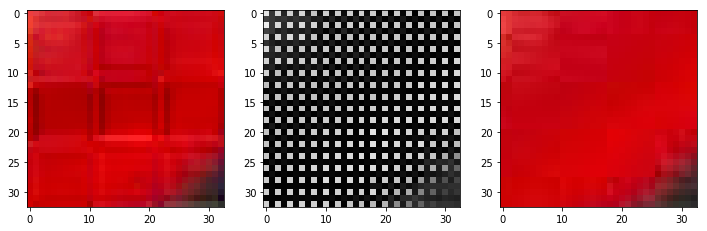

Epoch [5/250], Step [0/196], Loss: 0.010885673575103283
Epoch [5/250], Step [50/196], Loss: 0.015796305611729622
Epoch [5/250], Step [100/196], Loss: 0.010792827233672142
Epoch [5/250], Step [150/196], Loss: 0.0083544896915555

Finished Epoch 5, Loss --- mean: 0.012891998459889116, std 0.005587584327954169



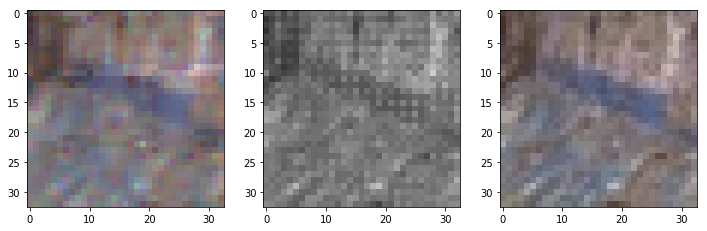

Epoch [6/250], Step [0/196], Loss: 0.014311656355857849
Epoch [6/250], Step [50/196], Loss: 0.0067375958897173405
Epoch [6/250], Step [100/196], Loss: 0.006483413279056549
Epoch [6/250], Step [150/196], Loss: 0.0072473688051104546


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 6, Loss --- mean: 0.007579535036822971, std 0.0015109211304645653



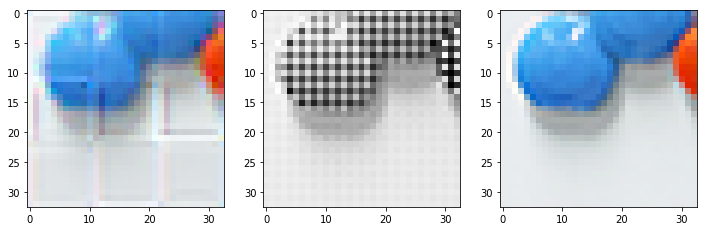

Epoch [7/250], Step [0/196], Loss: 0.006834069732576609
Epoch [7/250], Step [50/196], Loss: 0.008952620439231396
Epoch [7/250], Step [100/196], Loss: 0.006127071566879749
Epoch [7/250], Step [150/196], Loss: 0.010369078256189823


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 7, Loss --- mean: 0.011769539367749679, std 0.007257017666579426



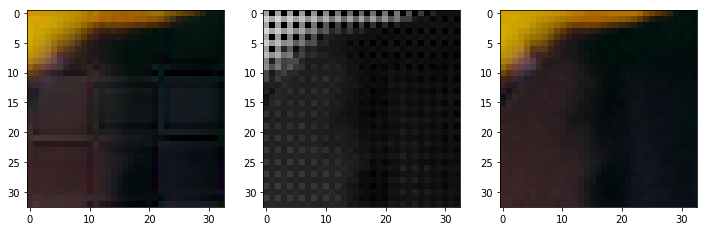

Epoch [8/250], Step [0/196], Loss: 0.008243381977081299
Epoch [8/250], Step [50/196], Loss: 0.0073426407761871815
Epoch [8/250], Step [100/196], Loss: 0.007946927100419998
Epoch [8/250], Step [150/196], Loss: 0.0062699331901967525


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 8, Loss --- mean: 0.015626328562538386, std 0.0213001144550037



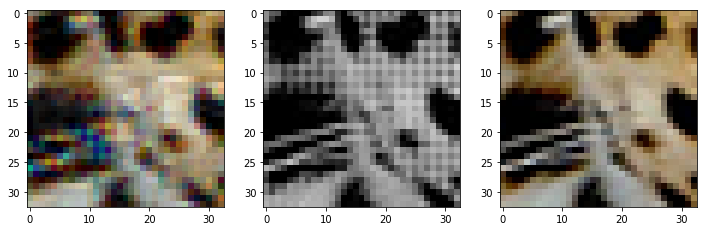

Epoch [9/250], Step [0/196], Loss: 0.02996545471251011
Epoch [9/250], Step [50/196], Loss: 0.012366138398647308
Epoch [9/250], Step [100/196], Loss: 0.010779288597404957
Epoch [9/250], Step [150/196], Loss: 0.01205501239746809


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 9, Loss --- mean: 0.015430137581591095, std 0.02456550453315081



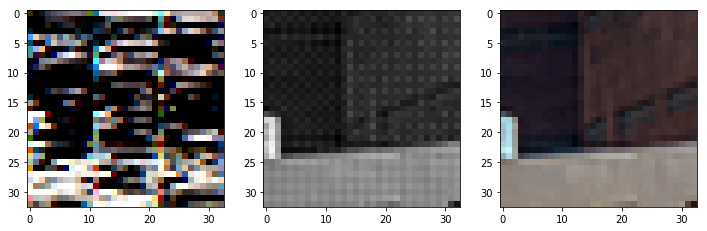

Epoch [10/250], Step [0/196], Loss: 0.04180314391851425
Epoch [10/250], Step [50/196], Loss: 0.016033925116062164
Epoch [10/250], Step [100/196], Loss: 0.01158857811242342
Epoch [10/250], Step [150/196], Loss: 0.009508790448307991


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 10, Loss --- mean: 0.015802272072784146, std 0.010928561384475902



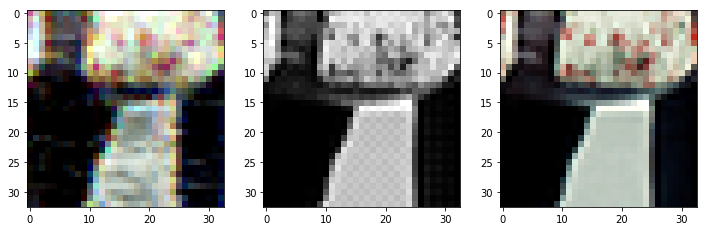

Epoch [11/250], Step [0/196], Loss: 0.007514946162700653
Epoch [11/250], Step [50/196], Loss: 0.006657694466412067
Epoch [11/250], Step [100/196], Loss: 0.00574088329449296
Epoch [11/250], Step [150/196], Loss: 0.0061870296485722065

Finished Epoch 11, Loss --- mean: 0.007040233954749241, std 0.0011653937300288633



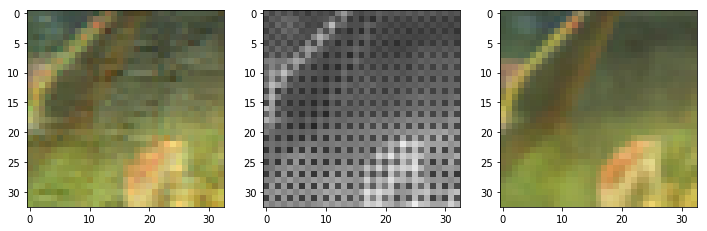

Epoch [12/250], Step [0/196], Loss: 0.005633610766381025
Epoch [12/250], Step [50/196], Loss: 0.01570083573460579
Epoch [12/250], Step [100/196], Loss: 0.006913430988788605
Epoch [12/250], Step [150/196], Loss: 0.006137479096651077


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 12, Loss --- mean: 0.007017979118022688, std 0.0018832794603618193



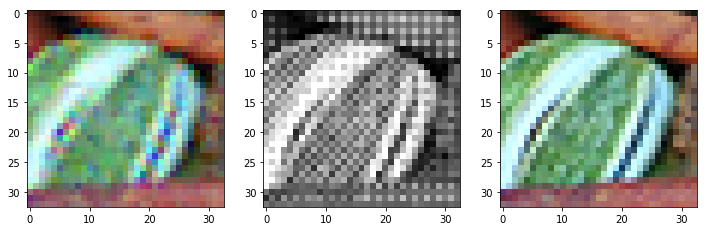

Epoch [13/250], Step [0/196], Loss: 0.0067204744555056095
Epoch [13/250], Step [50/196], Loss: 0.006628206931054592
Epoch [13/250], Step [100/196], Loss: 0.004702258389443159
Epoch [13/250], Step [150/196], Loss: 0.005488148890435696


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 13, Loss --- mean: 0.006080107801422781, std 0.006453331944663794



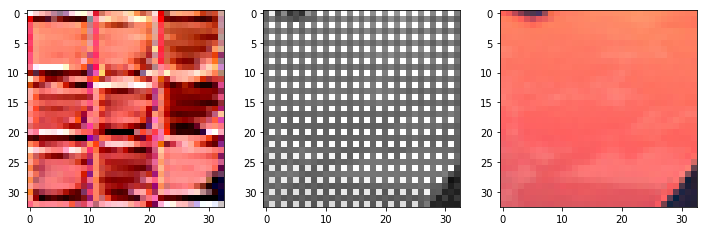

Epoch [14/250], Step [0/196], Loss: 0.01698646880686283
Epoch [14/250], Step [50/196], Loss: 0.032467227429151535
Epoch [14/250], Step [100/196], Loss: 0.012678055092692375
Epoch [14/250], Step [150/196], Loss: 0.01080702431499958


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 14, Loss --- mean: 0.017493763251933366, std 0.011477992013179885



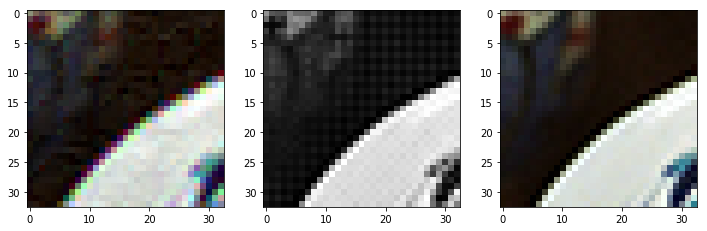

Epoch [15/250], Step [0/196], Loss: 0.009141254238784313
Epoch [15/250], Step [50/196], Loss: 0.006638235412538052
Epoch [15/250], Step [100/196], Loss: 0.006772369612008333
Epoch [15/250], Step [150/196], Loss: 0.008919550105929375


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 15, Loss --- mean: 0.007576038029843143, std 0.001357125439506391



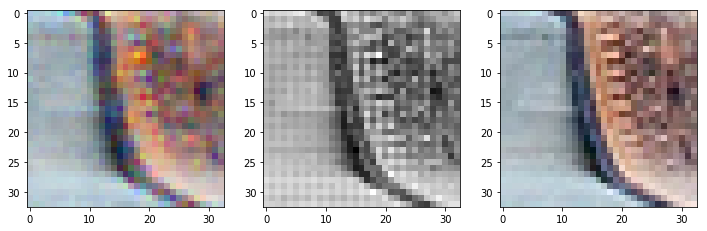

Epoch [16/250], Step [0/196], Loss: 0.006044887006282806
Epoch [16/250], Step [50/196], Loss: 0.0061358315870165825
Epoch [16/250], Step [100/196], Loss: 0.005197714548557997
Epoch [16/250], Step [150/196], Loss: 0.005247488152235746


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 16, Loss --- mean: 0.005877125661402028, std 0.0008216057388788757



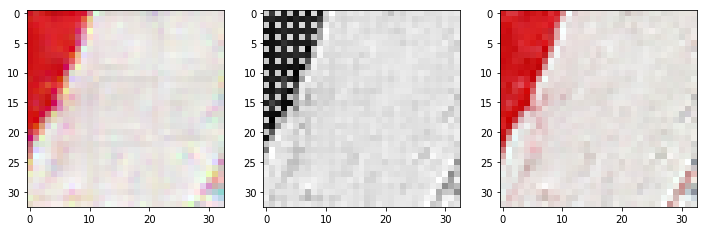

Epoch [17/250], Step [0/196], Loss: 0.0063371434807777405
Epoch [17/250], Step [50/196], Loss: 0.005600109696388245
Epoch [17/250], Step [100/196], Loss: 0.005899400915950537
Epoch [17/250], Step [150/196], Loss: 0.0048536271788179874


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 17, Loss --- mean: 0.005492215413049015, std 0.0006770430798210575



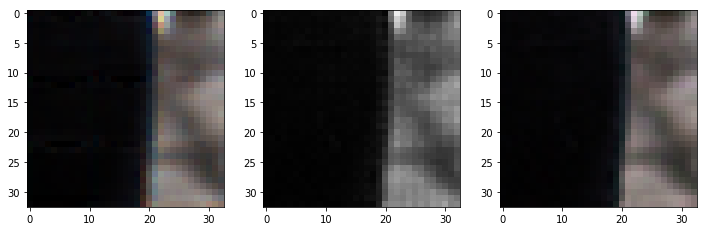

Epoch [18/250], Step [0/196], Loss: 0.005104301031678915
Epoch [18/250], Step [50/196], Loss: 0.007228964474052191
Epoch [18/250], Step [100/196], Loss: 0.005915819201618433
Epoch [18/250], Step [150/196], Loss: 0.004636887926608324


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 18, Loss --- mean: 0.005586717945371507, std 0.0010825926330869948



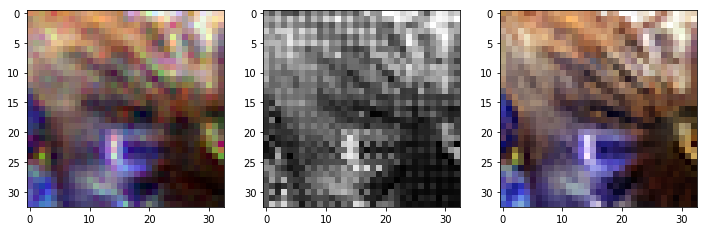

Epoch [19/250], Step [0/196], Loss: 0.004711806774139404
Epoch [19/250], Step [50/196], Loss: 0.005325241480022669
Epoch [19/250], Step [100/196], Loss: 0.005541494116187096
Epoch [19/250], Step [150/196], Loss: 0.0055550504475831985

Finished Epoch 19, Loss --- mean: 0.005013046419124442, std 0.0005921757431433338



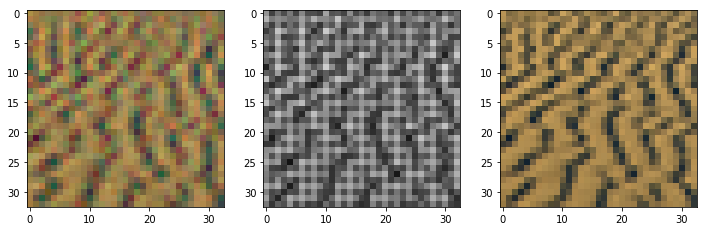

Epoch [20/250], Step [0/196], Loss: 0.004079732112586498
Epoch [20/250], Step [50/196], Loss: 0.009754217229783535
Epoch [20/250], Step [100/196], Loss: 0.007173591293394566
Epoch [20/250], Step [150/196], Loss: 0.004496452864259481


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 20, Loss --- mean: 0.006414262318926655, std 0.0017612581485947788



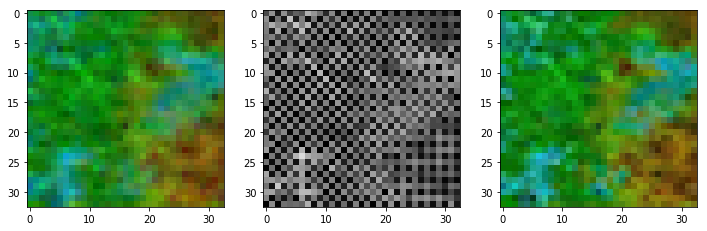

Epoch [21/250], Step [0/196], Loss: 0.0057380530051887035
Epoch [21/250], Step [50/196], Loss: 0.00549306022003293
Epoch [21/250], Step [100/196], Loss: 0.004733208101242781
Epoch [21/250], Step [150/196], Loss: 0.00445983000099659


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 21, Loss --- mean: 0.005758883311574784, std 0.01122650130968382



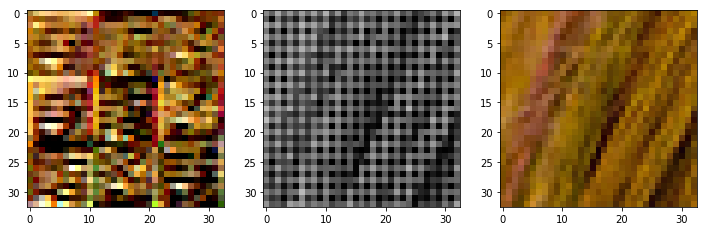

Epoch [22/250], Step [0/196], Loss: 0.015213508158922195
Epoch [22/250], Step [50/196], Loss: 0.00642447778955102
Epoch [22/250], Step [100/196], Loss: 0.005375081207603216
Epoch [22/250], Step [150/196], Loss: 0.0037743013817816973


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 22, Loss --- mean: 0.006286162431636939, std 0.0024331730813276467



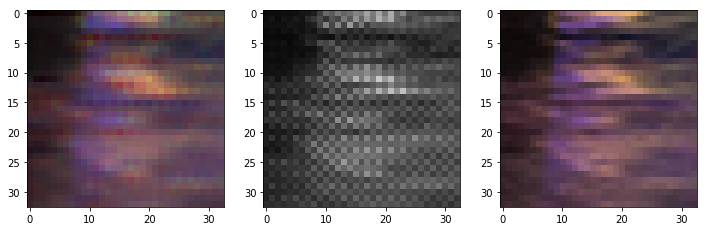

Epoch [23/250], Step [0/196], Loss: 0.007611865643411875
Epoch [23/250], Step [50/196], Loss: 0.005911232903599739
Epoch [23/250], Step [100/196], Loss: 0.005546265747398138
Epoch [23/250], Step [150/196], Loss: 0.006223130505532026


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 23, Loss --- mean: 0.005543905443378857, std 0.0008884497073163315



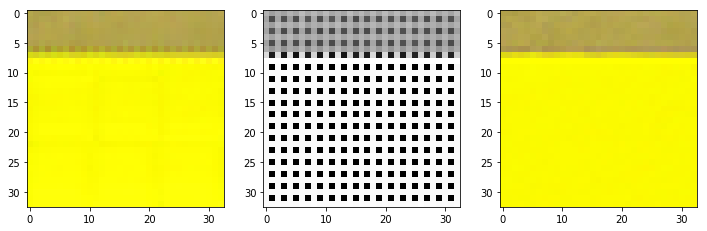

Epoch [24/250], Step [0/196], Loss: 0.004645891021937132
Epoch [24/250], Step [50/196], Loss: 0.00463464017957449
Epoch [24/250], Step [100/196], Loss: 0.004363992251455784
Epoch [24/250], Step [150/196], Loss: 0.00792932789772749


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 24, Loss --- mean: 0.0053149144265002436, std 0.0010911032436879463



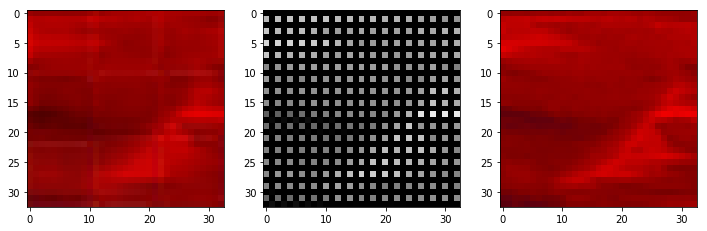

Epoch [25/250], Step [0/196], Loss: 0.003957564942538738
Epoch [25/250], Step [50/196], Loss: 0.004156946670264006
Epoch [25/250], Step [100/196], Loss: 0.005099484231323004
Epoch [25/250], Step [150/196], Loss: 0.00513929408043623


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 25, Loss --- mean: 0.005724710133164285, std 0.0037713886200099554



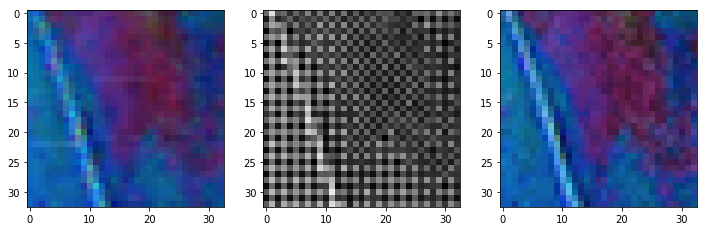

Epoch [26/250], Step [0/196], Loss: 0.005678470712155104
Epoch [26/250], Step [50/196], Loss: 0.00498514249920845
Epoch [26/250], Step [100/196], Loss: 0.0055929748341441154
Epoch [26/250], Step [150/196], Loss: 0.005020095966756344


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 26, Loss --- mean: 0.005746286237678889, std 0.0034596155256616658



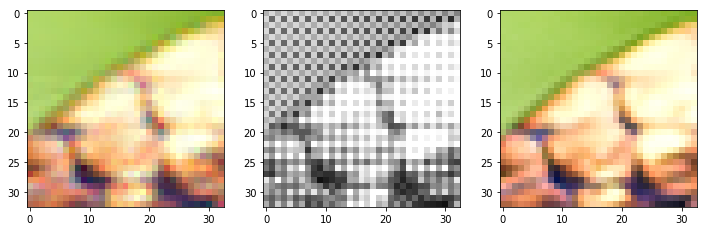

Epoch [27/250], Step [0/196], Loss: 0.00464019738137722
Epoch [27/250], Step [50/196], Loss: 0.0040924567729234695
Epoch [27/250], Step [100/196], Loss: 0.004888557363301516
Epoch [27/250], Step [150/196], Loss: 0.00415544118732214

Finished Epoch 27, Loss --- mean: 0.004359347417912617, std 0.0004996034748575233



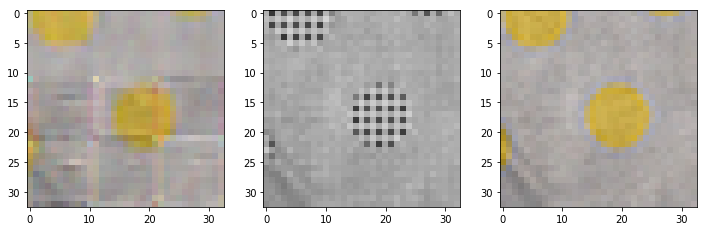

Epoch [28/250], Step [0/196], Loss: 0.004431747831404209
Epoch [28/250], Step [50/196], Loss: 0.004320955369621515
Epoch [28/250], Step [100/196], Loss: 0.00409700395539403
Epoch [28/250], Step [150/196], Loss: 0.004191373009234667

Finished Epoch 28, Loss --- mean: 0.00411877482986952, std 0.00046850162342741247



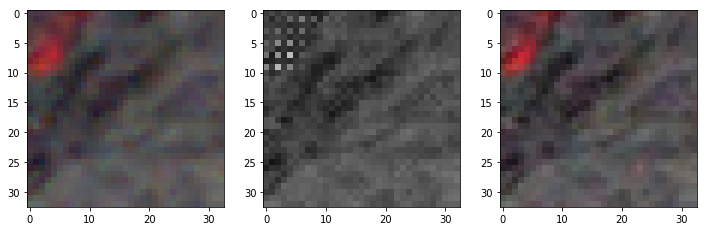

Epoch [29/250], Step [0/196], Loss: 0.0029948928859084845
Epoch [29/250], Step [50/196], Loss: 0.0034846733324229717
Epoch [29/250], Step [100/196], Loss: 0.003100090194493532
Epoch [29/250], Step [150/196], Loss: 0.004153572954237461

Finished Epoch 29, Loss --- mean: 0.0038635593919767713, std 0.0004310641307474469



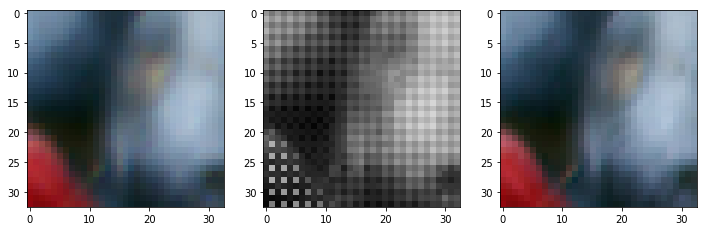

Epoch [30/250], Step [0/196], Loss: 0.003923261538147926
Epoch [30/250], Step [50/196], Loss: 0.0032610397320240736
Epoch [30/250], Step [100/196], Loss: 0.0036118223797529936
Epoch [30/250], Step [150/196], Loss: 0.0035089990124106407


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 30, Loss --- mean: 0.0038619966136899833, std 0.00046971585514948367



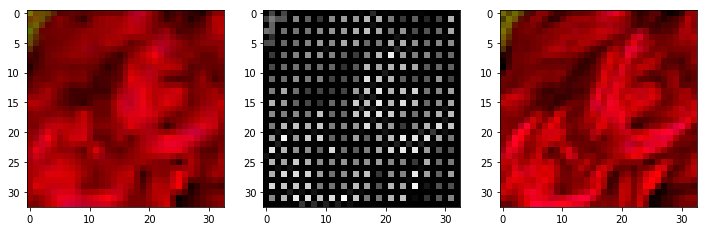

Epoch [31/250], Step [0/196], Loss: 0.004042521119117737
Epoch [31/250], Step [50/196], Loss: 0.004464880563318729
Epoch [31/250], Step [100/196], Loss: 0.004010539967566729
Epoch [31/250], Step [150/196], Loss: 0.0036402931436896324

Finished Epoch 31, Loss --- mean: 0.0038643376818591996, std 0.00040529258797036155



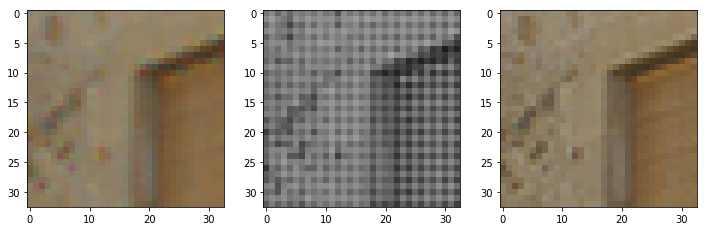

Epoch [32/250], Step [0/196], Loss: 0.004127128981053829
Epoch [32/250], Step [50/196], Loss: 0.0037894935812801123
Epoch [32/250], Step [100/196], Loss: 0.0047043138183653355
Epoch [32/250], Step [150/196], Loss: 0.004445140715688467


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 32, Loss --- mean: 0.00386006917034713, std 0.00044810733065321585



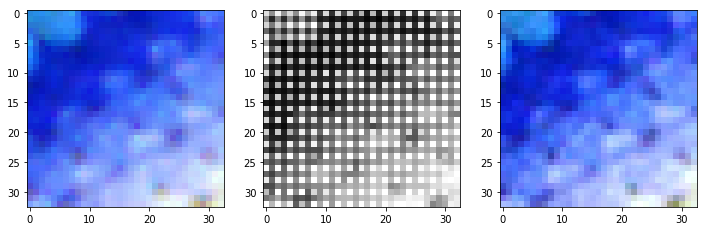

Epoch [33/250], Step [0/196], Loss: 0.0038593688514083624
Epoch [33/250], Step [50/196], Loss: 0.0032038334757089615
Epoch [33/250], Step [100/196], Loss: 0.00422385148704052
Epoch [33/250], Step [150/196], Loss: 0.003724317532032728


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 33, Loss --- mean: 0.0038585384086496674, std 0.0004801716279000534



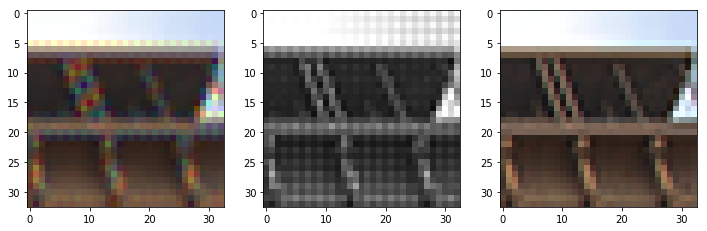

Epoch [34/250], Step [0/196], Loss: 0.0039319731295108795
Epoch [34/250], Step [50/196], Loss: 0.004442117642611265
Epoch [34/250], Step [100/196], Loss: 0.004036783240735531
Epoch [34/250], Step [150/196], Loss: 0.004034702200442553


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 34, Loss --- mean: 0.0038610288174822927, std 0.000450788473819801



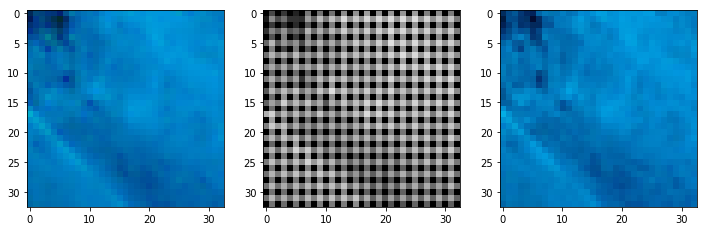

Epoch [35/250], Step [0/196], Loss: 0.00425668666139245
Epoch [35/250], Step [50/196], Loss: 0.004768898244947195
Epoch [35/250], Step [100/196], Loss: 0.004099071025848389
Epoch [35/250], Step [150/196], Loss: 0.003603030228987336

Finished Epoch 35, Loss --- mean: 0.003862146632650829, std 0.00047219962923533373



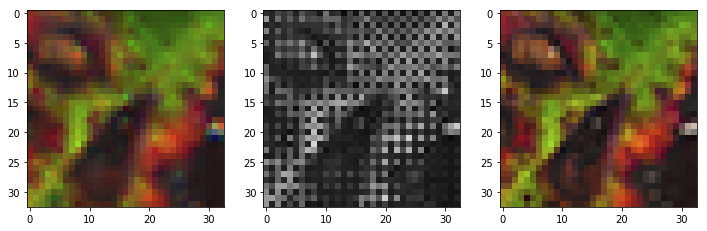

Epoch [36/250], Step [0/196], Loss: 0.003805029671639204
Epoch [36/250], Step [50/196], Loss: 0.003931766375899315
Epoch [36/250], Step [100/196], Loss: 0.003725199494510889
Epoch [36/250], Step [150/196], Loss: 0.004120843484997749


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 36, Loss --- mean: 0.0038613320342550167, std 0.0004993908563508891



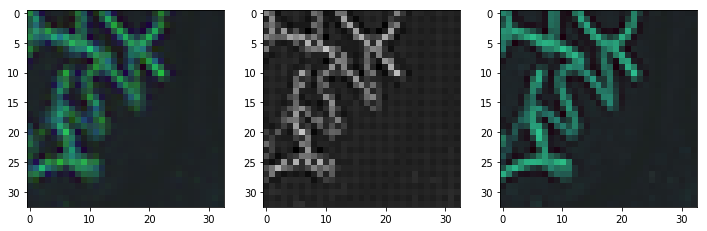

Epoch [37/250], Step [0/196], Loss: 0.0033060575369745493
Epoch [37/250], Step [50/196], Loss: 0.0038300117012113333
Epoch [37/250], Step [100/196], Loss: 0.004539537243545055
Epoch [37/250], Step [150/196], Loss: 0.0036988400388509035

Finished Epoch 37, Loss --- mean: 0.003867746122913169, std 0.0004677943657746585



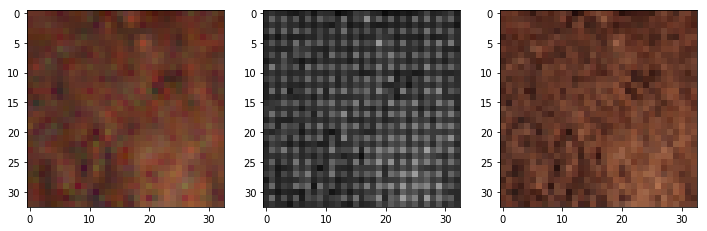

Epoch [38/250], Step [0/196], Loss: 0.003100947244092822
Epoch [38/250], Step [50/196], Loss: 0.003831758862361312
Epoch [38/250], Step [100/196], Loss: 0.004055341240018606
Epoch [38/250], Step [150/196], Loss: 0.003372003324329853


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 38, Loss --- mean: 0.003858312573616526, std 0.0004687133211503465



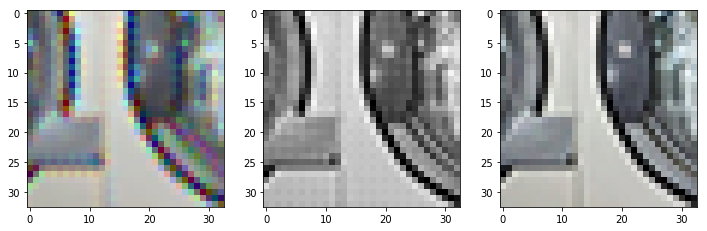

Epoch [39/250], Step [0/196], Loss: 0.004077305551618338
Epoch [39/250], Step [50/196], Loss: 0.00410422682762146
Epoch [39/250], Step [100/196], Loss: 0.002798703033477068
Epoch [39/250], Step [150/196], Loss: 0.004327163565903902


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 39, Loss --- mean: 0.0038619053476414054, std 0.00043955961288691105



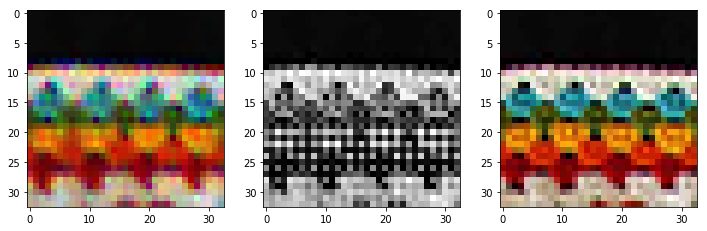

Epoch [40/250], Step [0/196], Loss: 0.0035106150899082422
Epoch [40/250], Step [50/196], Loss: 0.003956357017159462
Epoch [40/250], Step [100/196], Loss: 0.004581842105835676
Epoch [40/250], Step [150/196], Loss: 0.003689988050609827


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 40, Loss --- mean: 0.0038577652042161444, std 0.00042847060304768494



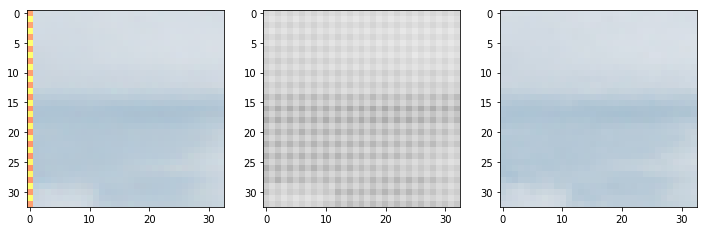

Epoch [41/250], Step [0/196], Loss: 0.003901541465893388
Epoch [41/250], Step [50/196], Loss: 0.003440047847107053
Epoch [41/250], Step [100/196], Loss: 0.0033194206189364195
Epoch [41/250], Step [150/196], Loss: 0.003982107155025005

Finished Epoch 41, Loss --- mean: 0.0038611401307244537, std 0.00046799062706165493



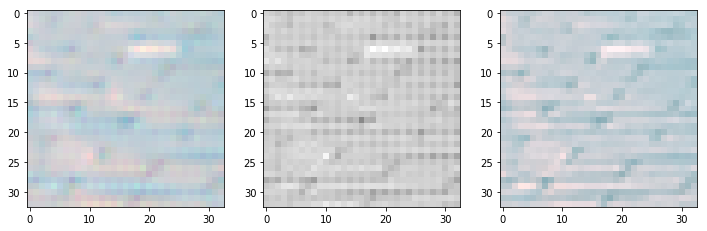

Epoch [42/250], Step [0/196], Loss: 0.0037226248532533646
Epoch [42/250], Step [50/196], Loss: 0.0036808897275477648
Epoch [42/250], Step [100/196], Loss: 0.0050343978218734264
Epoch [42/250], Step [150/196], Loss: 0.0038001700304448605


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 42, Loss --- mean: 0.0038654631531170134, std 0.0004621659716381234



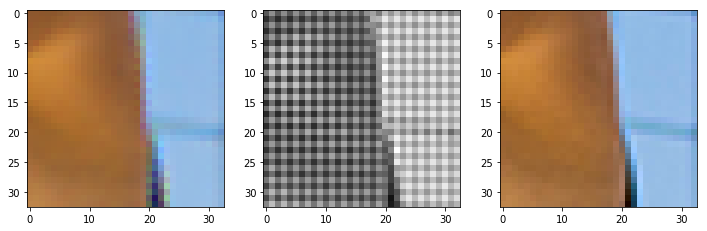

Epoch [43/250], Step [0/196], Loss: 0.0036599684972316027
Epoch [43/250], Step [50/196], Loss: 0.0031399219296872616
Epoch [43/250], Step [100/196], Loss: 0.003962801303714514
Epoch [43/250], Step [150/196], Loss: 0.0035177527461200953

Finished Epoch 43, Loss --- mean: 0.00386252238329652, std 0.00045538055982590825



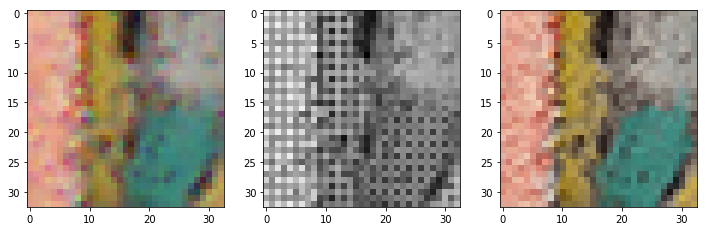

Epoch [44/250], Step [0/196], Loss: 0.0037749100010842085
Epoch [44/250], Step [50/196], Loss: 0.003954893443733454
Epoch [44/250], Step [100/196], Loss: 0.0038304307963699102
Epoch [44/250], Step [150/196], Loss: 0.004145950544625521

Finished Epoch 44, Loss --- mean: 0.003862337800864206, std 0.00042498854801791106



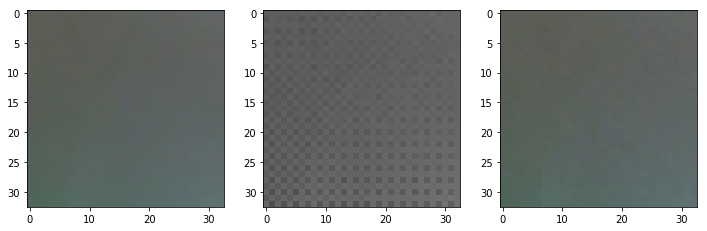

Epoch [45/250], Step [0/196], Loss: 0.0035714861005544662
Epoch [45/250], Step [50/196], Loss: 0.003570062341168523
Epoch [45/250], Step [100/196], Loss: 0.0040555913001298904
Epoch [45/250], Step [150/196], Loss: 0.0038744148332625628


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 45, Loss --- mean: 0.0038594964497285535, std 0.0004060260181629577



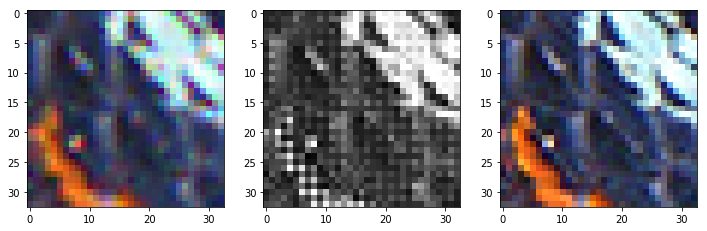

Epoch [46/250], Step [0/196], Loss: 0.003580783260986209
Epoch [46/250], Step [50/196], Loss: 0.004782383795827627
Epoch [46/250], Step [100/196], Loss: 0.002898569218814373
Epoch [46/250], Step [150/196], Loss: 0.0032418696209788322


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 46, Loss --- mean: 0.003855024850499645, std 0.0004400062117930322



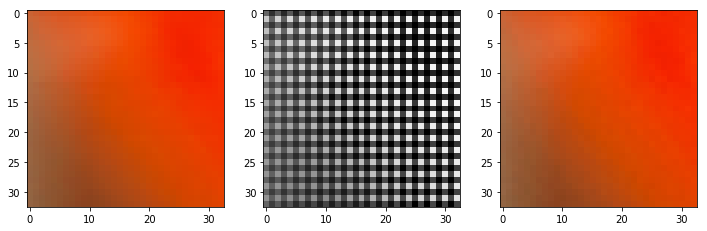

Epoch [47/250], Step [0/196], Loss: 0.003740986343473196
Epoch [47/250], Step [50/196], Loss: 0.003236970864236355
Epoch [47/250], Step [100/196], Loss: 0.0044661094434559345
Epoch [47/250], Step [150/196], Loss: 0.0033554518595337868


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 47, Loss --- mean: 0.0038492639480177692, std 0.0004384837157315913



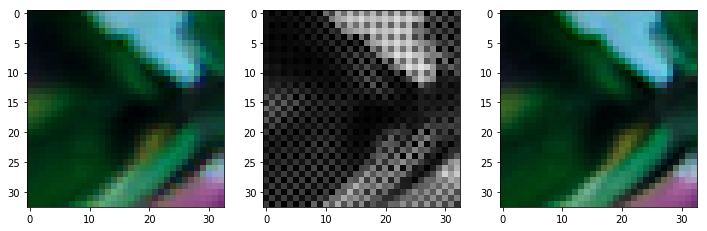

Epoch [48/250], Step [0/196], Loss: 0.0043022362515330315
Epoch [48/250], Step [50/196], Loss: 0.0033082428853958845
Epoch [48/250], Step [100/196], Loss: 0.003193147014826536
Epoch [48/250], Step [150/196], Loss: 0.004094512667506933


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 48, Loss --- mean: 0.003840886733532712, std 0.00040322806902551284



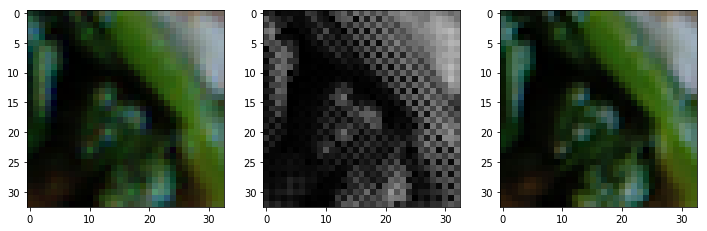

Epoch [49/250], Step [0/196], Loss: 0.00392500963062048
Epoch [49/250], Step [50/196], Loss: 0.0037836364936083555
Epoch [49/250], Step [100/196], Loss: 0.0036283668596297503
Epoch [49/250], Step [150/196], Loss: 0.003327540121972561

Finished Epoch 49, Loss --- mean: 0.00383895981643463, std 0.00044478377021953727



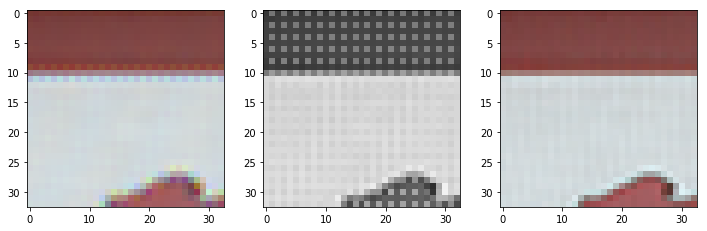

Epoch [50/250], Step [0/196], Loss: 0.003593065543100238
Epoch [50/250], Step [50/196], Loss: 0.0033474545925855637
Epoch [50/250], Step [100/196], Loss: 0.004298570100218058
Epoch [50/250], Step [150/196], Loss: 0.0037960342597216368

Finished Epoch 50, Loss --- mean: 0.0038343801802233316, std 0.0003935456106905941



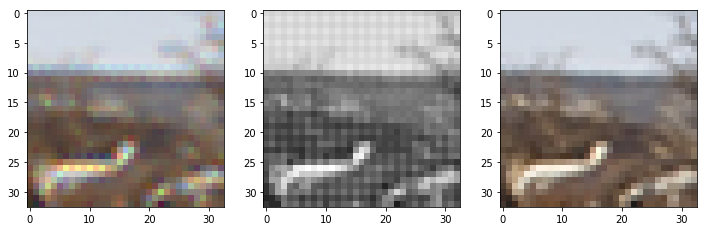

Epoch [51/250], Step [0/196], Loss: 0.00401828670874238
Epoch [51/250], Step [50/196], Loss: 0.004460048396140337
Epoch [51/250], Step [100/196], Loss: 0.004889864008873701
Epoch [51/250], Step [150/196], Loss: 0.003978243097662926

Finished Epoch 51, Loss --- mean: 0.003828990696074099, std 0.00043046478434963903



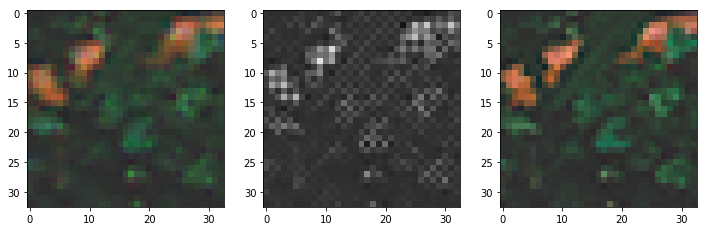

Epoch [52/250], Step [0/196], Loss: 0.004087913315743208
Epoch [52/250], Step [50/196], Loss: 0.0038185890298336744
Epoch [52/250], Step [100/196], Loss: 0.004135706461966038
Epoch [52/250], Step [150/196], Loss: 0.004215980414301157

Finished Epoch 52, Loss --- mean: 0.003826900891370463, std 0.0004244640331278709



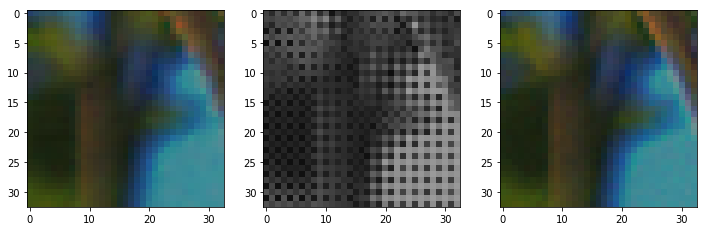

Epoch [53/250], Step [0/196], Loss: 0.004078196827322245
Epoch [53/250], Step [50/196], Loss: 0.0035198843106627464
Epoch [53/250], Step [100/196], Loss: 0.0038782458286732435
Epoch [53/250], Step [150/196], Loss: 0.004320571664720774

Finished Epoch 53, Loss --- mean: 0.003820389283497875, std 0.00043285606291095744



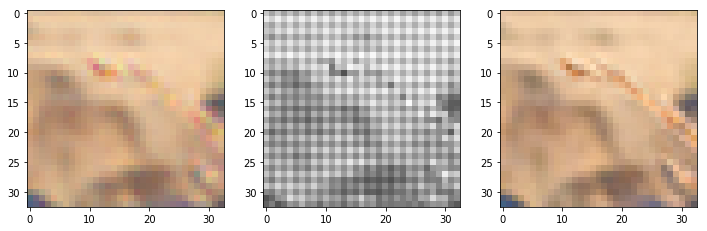

Epoch [54/250], Step [0/196], Loss: 0.003930268809199333
Epoch [54/250], Step [50/196], Loss: 0.0035778561141341925
Epoch [54/250], Step [100/196], Loss: 0.0037949534598737955
Epoch [54/250], Step [150/196], Loss: 0.004031266085803509


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 54, Loss --- mean: 0.0038135009152548654, std 0.0004052363560980247



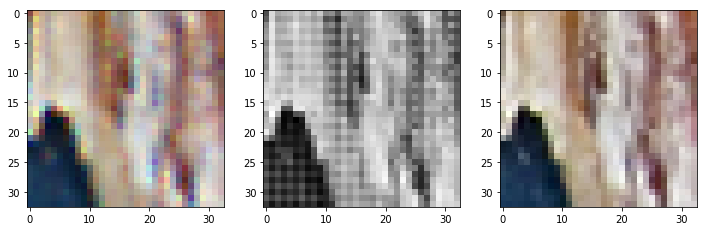

Epoch [55/250], Step [0/196], Loss: 0.004273578524589539
Epoch [55/250], Step [50/196], Loss: 0.0048197489231824875
Epoch [55/250], Step [100/196], Loss: 0.0036679913755506277
Epoch [55/250], Step [150/196], Loss: 0.0038230237551033497

Finished Epoch 55, Loss --- mean: 0.003796220736872709, std 0.00043421163943520904



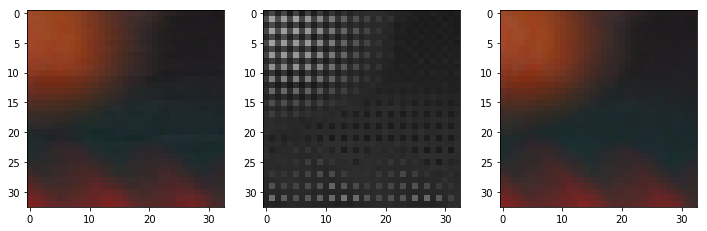

Epoch [56/250], Step [0/196], Loss: 0.003977710846811533
Epoch [56/250], Step [50/196], Loss: 0.004142689052969217
Epoch [56/250], Step [100/196], Loss: 0.0035853320732712746
Epoch [56/250], Step [150/196], Loss: 0.005016964394599199


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 56, Loss --- mean: 0.0037880013459267057, std 0.00041162716571506257



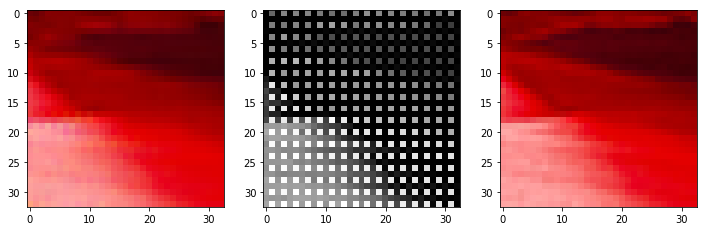

Epoch [57/250], Step [0/196], Loss: 0.00395673792809248
Epoch [57/250], Step [50/196], Loss: 0.004100535064935684
Epoch [57/250], Step [100/196], Loss: 0.004497365560382605
Epoch [57/250], Step [150/196], Loss: 0.003907499369233847

Finished Epoch 57, Loss --- mean: 0.0037723765257099756, std 0.0004153751339828644



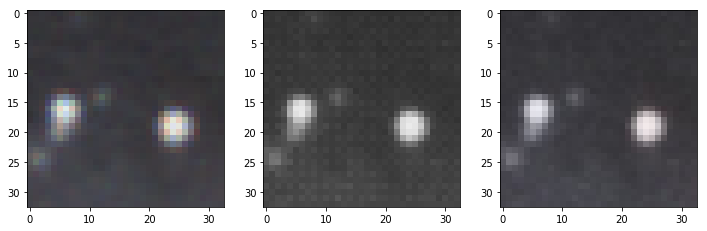

Epoch [58/250], Step [0/196], Loss: 0.00455477274954319
Epoch [58/250], Step [50/196], Loss: 0.004021264612674713
Epoch [58/250], Step [100/196], Loss: 0.003661719849333167
Epoch [58/250], Step [150/196], Loss: 0.003965534269809723


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 58, Loss --- mean: 0.003760115026106716, std 0.0004110257197758294



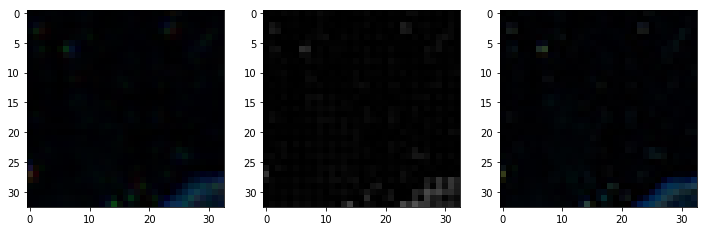

Epoch [59/250], Step [0/196], Loss: 0.003931626211851835
Epoch [59/250], Step [50/196], Loss: 0.0037492229603230953
Epoch [59/250], Step [100/196], Loss: 0.003738217754289508
Epoch [59/250], Step [150/196], Loss: 0.003481303108856082


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 59, Loss --- mean: 0.003745476256732886, std 0.00040273705504611157



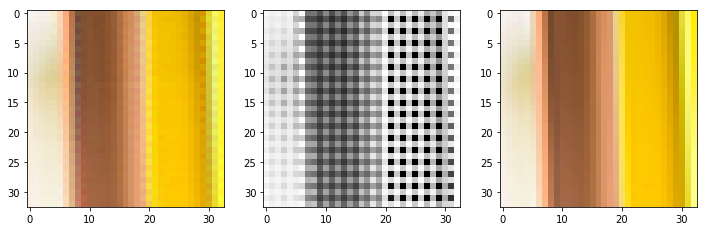

Epoch [60/250], Step [0/196], Loss: 0.00333013036288321


KeyboardInterrupt: 

In [22]:
total_step = len(data_loader)
loss_list = []
for epoch in range(start_epoch, n_epochs):
    epoch_loss = []
    for idx, (cfa, target, bilin) in enumerate(data_loader):
        cfa = cfa.float().to(device)
        target = target.float().to(device)
        bilin = bilin.float().to(device)
        target.cuda()
        outputs = model_vd(cfa)
        
        #print(outputs.shape, target.shape)
        loss = criterion(outputs + bilin, target)
        epoch_loss.append(loss.item())

        optimizer_vd.zero_grad()
        loss.backward()
        optimizer_vd.step()

        if idx % 50 == 0:
            print(f'Epoch [{epoch}/{n_epochs}], Step [{idx}/{total_step}], Loss: {loss.item()}')
    epoch_stats = np.array(epoch_loss)
    print(f'\nFinished Epoch {epoch}, Loss --- mean: {epoch_stats.mean()}, std {epoch_stats.std()}\n')
    loss_list.append(epoch_stats.mean())
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,8))
    ax1.imshow(np.array(outputs[-1].tolist()).reshape((33, 33, 3)) + np.array(bilin[-1].tolist()).reshape((33, 33, 3)))
    ax2.imshow(np.array(cfa[-1].tolist()).reshape((33, 33, 3)), cmap='gray')
    ax3.imshow(np.array(target[-1].tolist()).reshape((33, 33, 3)))
    #plt.savefig(f'epoch{epoch}.png')

    #checkpoint(os.path.join(weights_path, f'dmcnn_vd_{epoch}.weight'), model_vd, optimizer_vd, loss, epoch=epoch)

    plt.show()

## Evaluation

We'll evaluate the models and compare it to some of the classical methods provided.

In [23]:
from colour_demosaicing import mosaicing_CFA_Bayer

In [24]:
lighthouse = cv2.cvtColor(cv2.imread('data/lighthouse.png'), cv2.COLOR_BGR2RGB)

Text(0.5, 1.0, 'lighthouse.png')

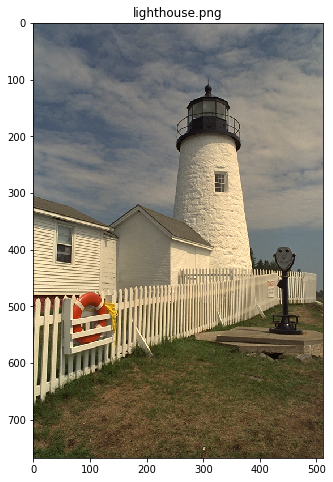

In [25]:
plt.figure(figsize=(10,8))
plt.imshow(lighthouse)
plt.title('lighthouse.png')

We'll turn the model to evaluation mode

In [45]:
model_vd = model_vd.eval()

Apply the Bayer mosaicing to the image

In [27]:
mosaic = mosaicing_CFA_Bayer(lighthouse)

Text(0.5, 1.0, 'lighthouse_mosaic.png')

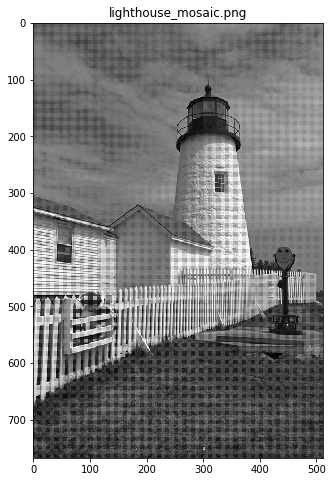

In [28]:
plt.figure(figsize=(10,8))
plt.imshow(mosaic, cmap='gray')
plt.title('lighthouse_mosaic.png')

In [29]:
bilin.dtype

torch.float64

Text(0.5, 1.0, 'lighthouse_bilin.png')

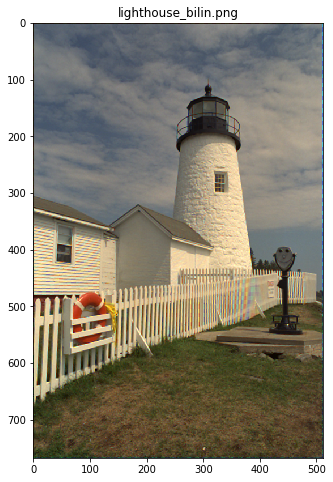

In [30]:
bilin = demosaicing_CFA_Bayer_bilinear(mosaic).astype(np.uint8)
plt.figure(figsize=(10,8))
plt.imshow(bilin, cmap='gray')
plt.title('lighthouse_bilin.png')

Splitting the image to the patches

In [31]:
image_patches = []
patches = []
bilin_patches = []
for i in range(33, mosaic.shape[0], 33):
    for j in range(33, mosaic.shape[1], 33):
        patch_mosaic = mosaic[i-33:i, j-33:j]
        patch = np.zeros((33, 33, 3), np.uint8)
        for idx in range(3):
            patch[:, :, idx] = patch_mosaic
        patches.append((i, j))
        image_patches.append(patch)
        bilin_patches.append(bilin[i-33:i, j-33:j, :])

Convert the patches to tensors and run them through the model

In [32]:
tensor_patches = torch.from_numpy(np.stack(image_patches).reshape((len(image_patches), 3, 33, 33)) / 255).float().to(device)

In [33]:
results = []
with torch.no_grad():
    for i in range(0, tensor_patches.shape[0], 128):
        input_patch = tensor_patches[i:i+128, :, :, :]
        outputs = model_vd(input_patch) + input_patch
        results.append(outputs)

In [34]:
results = torch.cat(results)

In [39]:
demosaiced = np.zeros(lighthouse.shape, np.uint8)

for idx, patch in enumerate(patches):
    i, j = patch
    demosaic_patch = results[idx, :, :, :].reshape(33, 33, 3)
    demosaiced[i-33:i, j-33:j, :] = np.array(demosaic_patch.tolist()) * 255 + bilin_patches[idx]

Text(0.5, 1.0, 'demosaic.png')

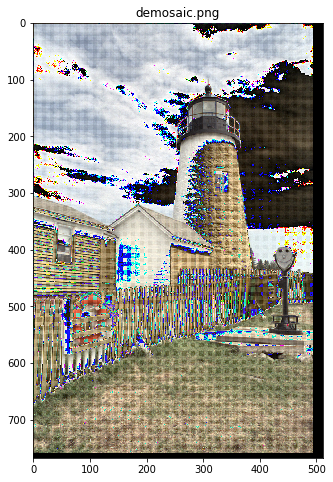

In [40]:
plt.figure(figsize=(10,8))
plt.imshow(demosaiced, cmap='gray')
plt.title('demosaic.png')